In [55]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent.parent
sys.path.append(str(PROJECT_ROOT))
print(f"Project root added to sys.path: {PROJECT_ROOT}")

Project root added to sys.path: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis


In [59]:
from config.settings import *

data_1m_path = DATA_CLEANED_DIR / 'data_1m.csv'
data_5m_path = DATA_CLEANED_DIR / 'data_5m.csv'
data_15m_path = DATA_CLEANED_DIR / 'data_15m.csv'

print(data_5m_path)

D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\data\cleaned\data_5m.csv


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import yaml
from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [61]:
def check_and_plot_data(df):
    print("\n--- INFO ---")
    print(df.info())
    
    print("\n--- STATISTICS ---")
    print(df.describe())
    
    plt.figure(figsize=(15, 6))
    plt.plot(df.index, df['requests_target'], label='Requests (Target)', color='#1f77b4', linewidth=1)
    
    # Highlight vùng Test (Sau ngày 23/08)
    test_start_date = '1995-08-23 00:00:00'
    plt.axvline(pd.to_datetime(test_start_date), color='red', linestyle='--', label='Train/Test Split')
    
    plt.title('Tổng quan dữ liệu Requests', fontsize=14)
    plt.ylabel('Số lượng Request')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [62]:
df_1m = pd.read_csv(data_1m_path, index_col=0, parse_dates=True)
df_5m = pd.read_csv(data_5m_path, index_col=0, parse_dates=True)
df_15m = pd.read_csv(data_15m_path, index_col=0, parse_dates=True)


--- INFO ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87840 entries, 1995-07-02 00:00:00-04:00 to 1995-08-31 23:59:00-04:00
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   requests             87840 non-null  int64  
 1   bytes                87840 non-null  int64  
 2   hosts                87840 non-null  int64  
 3   errors               87840 non-null  int64  
 4   error_rate           87840 non-null  float64
 5   requests_target      87840 non-null  int64  
 6   req_lag_1            87840 non-null  float64
 7   req_lag_12           87840 non-null  float64
 8   req_lag_288          87840 non-null  float64
 9   rolling_mean_1h      87840 non-null  float64
 10  rolling_std_1h       87840 non-null  float64
 11  rolling_mean_24h     87840 non-null  float64
 12  err_lag_1            87840 non-null  float64
 13  err_rolling_mean_1h  87840 non-null  float64
 14  hour_of_day          8784

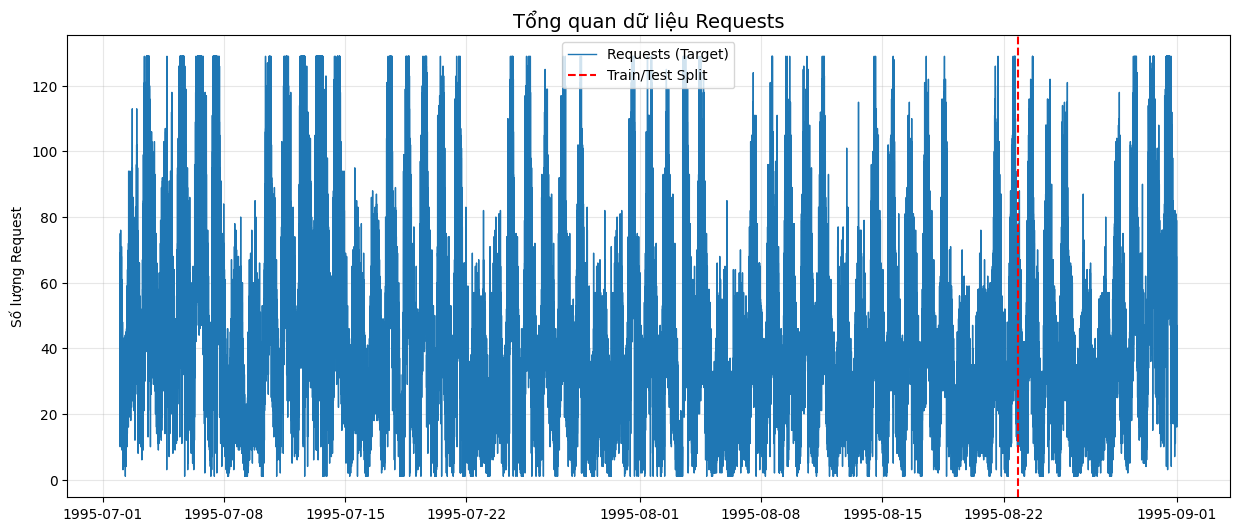

In [63]:
check_and_plot_data(df_1m)


--- INFO ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17568 entries, 1995-07-02 00:00:00-04:00 to 1995-08-31 23:55:00-04:00
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   requests             17568 non-null  int64  
 1   bytes                17568 non-null  int64  
 2   hosts                17568 non-null  int64  
 3   errors               17568 non-null  int64  
 4   error_rate           17568 non-null  float64
 5   requests_target      17568 non-null  int64  
 6   req_lag_1            17568 non-null  float64
 7   req_lag_12           17568 non-null  float64
 8   req_lag_288          17568 non-null  float64
 9   rolling_mean_1h      17568 non-null  float64
 10  rolling_std_1h       17568 non-null  float64
 11  rolling_mean_24h     17568 non-null  float64
 12  err_lag_1            17568 non-null  float64
 13  err_rolling_mean_1h  17568 non-null  float64
 14  hour_of_day          1756

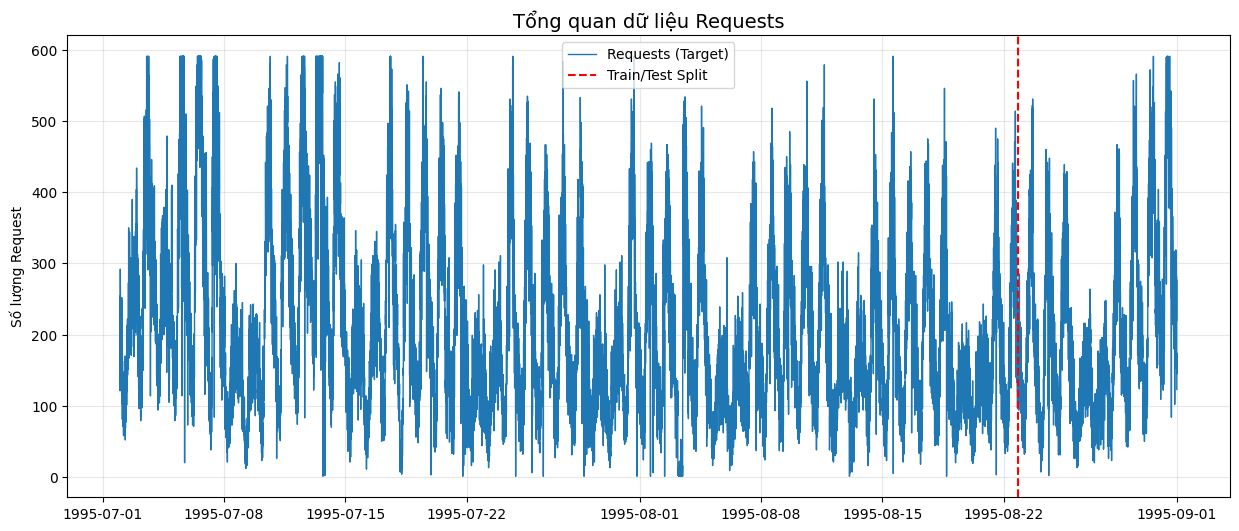

In [64]:
check_and_plot_data(df_5m)


--- INFO ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 1995-07-02 00:00:00-04:00 to 1995-08-31 23:45:00-04:00
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   requests             5856 non-null   int64  
 1   bytes                5856 non-null   int64  
 2   hosts                5856 non-null   int64  
 3   errors               5856 non-null   int64  
 4   error_rate           5856 non-null   float64
 5   requests_target      5856 non-null   int64  
 6   req_lag_1            5856 non-null   float64
 7   req_lag_12           5856 non-null   float64
 8   req_lag_288          5856 non-null   float64
 9   rolling_mean_1h      5856 non-null   float64
 10  rolling_std_1h       5856 non-null   float64
 11  rolling_mean_24h     5856 non-null   float64
 12  err_lag_1            5856 non-null   float64
 13  err_rolling_mean_1h  5856 non-null   float64
 14  hour_of_day          5856 

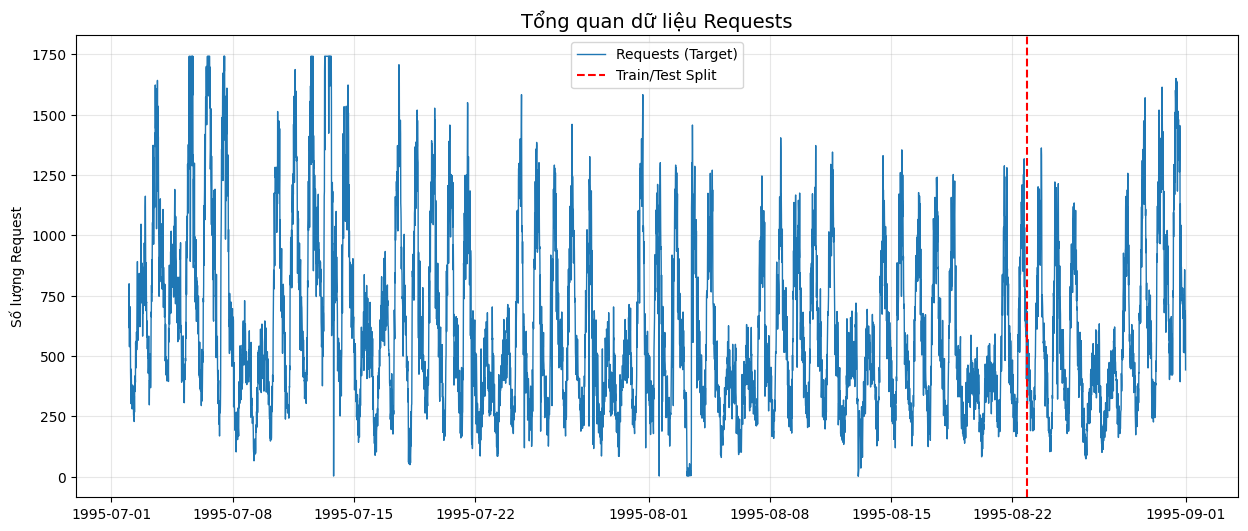

In [65]:
check_and_plot_data(df_15m)

In [66]:
df_5m.head(2)

,requests,bytes,hosts,errors,error_rate,requests_target,req_lag_1,req_lag_12,req_lag_288,rolling_mean_1h,rolling_std_1h,rolling_mean_24h,err_lag_1,err_rolling_mean_1h,hour_of_day,day_of_week,is_weekend,hour_sin,hour_cos,is_spike
timestamp,,,,,,,,,,,,,,,,,,,,
1995-07-02 00:00:00-04:00,243,4199114,50,3,0.012346,243,149.0,232.0,301.0,238.666667,56.633324,224.500000,0.013423,0.004610,0,6,1,0.0,1.0,0
1995-07-02 00:05:00-04:00,254,6328419,60,1,0.003937,254,243.0,235.0,267.0,240.250000,56.786882,224.454861,0.012346,0.004938,0,6,1,0.0,1.0,0


hour_cos      0.449940
is_weekend    0.322269
hour_sin      0.181027
error_rate    0.046764
dtype: float64


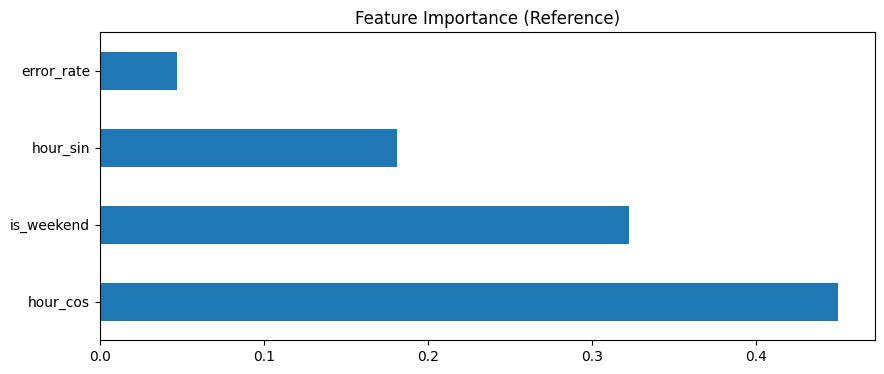


-> Features selected for LSTM: ['requests_target', 'error_rate', 'hour_sin', 'hour_cos', 'is_weekend']


In [67]:
def select_features_lstm(df):
    potential_cols = [ 'error_rate', 'hour_sin', 'hour_cos', 'is_weekend']
    
    X_check = df[potential_cols]
    y_check = df['requests_target']
    
    rf = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
    rf.fit(X_check, y_check)
    
    importances = pd.Series(rf.feature_importances_, index=potential_cols).sort_values(ascending=False)
    print(importances)
    plt.figure(figsize=(10, 4))
    importances.plot(kind='barh', title='Feature Importance (Reference)')
    plt.show()
 
    selected_features = ['requests_target', 'error_rate', 'hour_sin', 'hour_cos', 'is_weekend']
    print(f"\n-> Features selected for LSTM: {selected_features}")
    
    return df[selected_features]

df_lstm_input = select_features_lstm(df_5m)

In [68]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, sequence_length=12):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.X) - self.sequence_length

    def __getitem__(self, i):
        return self.X[i : i + self.sequence_length], self.y[i + self.sequence_length]

def prepare_data_pipeline(df, sequence_length=12, batch_size=32):
    """
    Quy trình: Split -> Scale -> Windowing -> DataLoader
    Tách: Train / Validation / Test
    """
    # Train: đến 16/08 (60%)
    # Validation: 17/08 - 22/08 (20%)
    # Test: từ 23/08 (20%)
    train_cutoff = '1995-08-16 23:59:59'
    val_cutoff = '1995-08-22 23:59:59'
    
    train_df = df[df.index <= train_cutoff]
    val_df = df[(df.index > train_cutoff) & (df.index <= val_cutoff)]
    test_df = df[df.index > val_cutoff]
    
    print(f"Train size: {len(train_df)} | Validation size: {len(val_df)} | Test size: {len(test_df)}")
    
    scaler_features = MinMaxScaler(feature_range=(0, 1))
    scaler_target = MinMaxScaler(feature_range=(0, 1))
    
    # Fit scalers on training data only
    scaler_features.fit(train_df)
    scaler_target.fit(train_df[['requests_target']])
    
    train_scaled = scaler_features.transform(train_df)
    val_scaled = scaler_features.transform(val_df)
    test_scaled = scaler_features.transform(test_df)
    
   
    train_dataset = TimeSeriesDataset(train_scaled, train_scaled[:, 0], sequence_length)
    val_dataset = TimeSeriesDataset(val_scaled, val_scaled[:, 0], sequence_length)
    test_dataset = TimeSeriesDataset(test_scaled, test_scaled[:, 0], sequence_length)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 
    
    return train_loader, val_loader, test_loader, scaler_target, scaler_features

In [69]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
      
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout)
        
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        # Lấy output tại bước thời gian cuối cùng (Last time step)
        out = out[:, -1, :]
        
        # Đưa qua lớp Dense
        out = self.fc(out)
        return out

In [70]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

In [71]:
def save_model_weights(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model weights saved to: {filepath}")


def load_model_weights(model, filepath):
    model.load_state_dict(torch.load(filepath, map_location=device))
    print(f"Model weights loaded from: {filepath}")
    return model


def train(model, train_loader, val_loader, epochs=20, lr=0.001, 
          patience=5, model_save_path=None):
    """
    Training model với Early Stopping trên Validation Set
    
    Parameters:
    model : torch.nn.Module
        LSTM model
    train_loader : DataLoader
        Training data loader
    val_loader : DataLoader
        Validation data loader (dùng cho early stopping)
    epochs : int
        Số epoch tối đa (default: 20)
    lr : float
        Learning rate (default: 0.001)
    patience : int
        Số epoch không cải thiện trước khi dừng (default: 5)
    model_save_path : str or Path
        Đường dẫn để lưu model weights tốt nhất (default: None - không lưu)
        
    Returns:
    --------
    dict : Dictionary chứa:
        - 'model': model đã train
        - 'train_losses': list train losses
        - 'val_losses': list validation losses
        - 'best_epoch': epoch có validation loss tốt nhất
        - 'best_val_loss': validation loss tốt nhất
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_epoch = 0
    
    print(f"Patience: {patience} epochs | Save path: {model_save_path}")
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # 1. Forward
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            
            # 2. Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs.squeeze(), y_val)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
      
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch + 1
            patience_counter = 0
            
            # Save best model weights
            if model_save_path is not None:
                save_model_weights(model, model_save_path)
                print(f'Epoch [{epoch+1}/{epochs}] ✓ Best Model! Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
            else:
                print(f'Epoch [{epoch+1}/{epochs}] ✓ Best! Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
        else:
            patience_counter += 1
            if (epoch+1) % 5 == 0:
                print(f'Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f} (Patience: {patience_counter}/{patience})')
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\n⚠️  Early Stopping! No improvement for {patience} epochs.")
            print(f"Best validation loss: {best_val_loss:.6f} at epoch {best_epoch}")
            break
    
    if model_save_path is not None:
        print(f"\nLoading best model weights from epoch {best_epoch}...")
        model = load_model_weights(model, model_save_path)
    
   
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', linewidth=2)
    plt.axvline(best_epoch-1, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Model Learning Curve with Early Stopping')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_epoch': best_epoch,
        'best_val_loss': best_val_loss,
    }


def evaluate(model, test_loader, scaler_target):
    """
    Returns:
    --------
    dict : Dictionary chứa:
        - 'predictions': array predictions (đơn vị thực tế)
        - 'actuals': array actual values (đơn vị thực tế)
        - 'metrics': dict chứa rmse, mse, mae, mape
    """
    print("\n--- EVALUATION ON TEST SET ---")
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            # Move về CPU và convert sang numpy
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(y_batch.numpy())
            
    # Inverse Transform về đơn vị request thực tế
    predictions = scaler_target.inverse_transform(np.array(predictions).reshape(-1, 1))
    actuals = scaler_target.inverse_transform(np.array(actuals).reshape(-1, 1))
    
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = calculate_mape(actuals, predictions)
    
    print(f"RMSE: {rmse:.2f}")
    print(f"MSE:  {mse:.2f}")
    print(f"MAE:  {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    
    # ===========================
    # Plot Predictions vs Actuals
    # ===========================
    plt.figure(figsize=(15, 6))
    plt.plot(actuals[:300], label='Actual Request', color='blue', linewidth=1.5)
    plt.plot(predictions[:300], label='LSTM Forecast', color='orange', linestyle='--', linewidth=1.5)
    plt.title('Dự báo vs Thực tế (Zoom in 300 điểm dữ liệu đầu tập Test)')
    plt.xlabel('Time Steps')
    plt.ylabel('Requests')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # ===========================
    # Plot Full Predictions
    # ===========================
    plt.figure(figsize=(15, 6))
    plt.plot(actuals, label='Actual Request', color='blue', linewidth=0.8, alpha=0.8)
    plt.plot(predictions, label='LSTM Forecast', color='orange', linestyle='--', linewidth=0.8, alpha=0.8)
    plt.title('Full Predictions vs Actuals trên toàn bộ tập Test')
    plt.xlabel('Time Steps')
    plt.ylabel('Requests')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return {
        'predictions': predictions,
        'actuals': actuals,
        'metrics': {
            'rmse': rmse,
            'mse': mse,
            'mae': mae,
            'mape': mape
        }
    }

In [72]:
# ===========================
# HYPERPARAMETER TUNING UTILITIES
# ===========================
import yaml
from datetime import datetime

def load_training_config(config_path=None):
    """
    Load training configuration từ YAML file
    
    Parameters:
    -----------
    config_path : str or Path
        Đường dẫn đến train_config.yaml (default: PROJECT_ROOT/config/train_config.yaml)
        
    Returns:
    --------
    dict : Configuration dictionary
    """
    if config_path is None:
        config_path = PROJECT_ROOT / 'config' / 'train_config.yaml'
    
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    
    print(f"✓ Loaded config from: {config_path}")
    return config


def get_model_config(config, model_name):
    """Lấy model configuration"""
    for model in config['model_configs']:
        if model['name'] == model_name:
            return model
    raise ValueError(f"Model '{model_name}' not found in config")


def get_training_config(config, training_name):
    """Lấy training configuration"""
    for training in config['training_configs']:
        if training['name'] == training_name:
            return training
    raise ValueError(f"Training config '{training_name}' not found in config")


def get_data_config(config, data_name):
    """Lấy data configuration"""
    for data in config['data_configs']:
        if data['name'] == data_name:
            return data
    raise ValueError(f"Data config '{data_name}' not found in config")


def run_hyperparameter_tuning(config, scaler_target, scaler_features, df_lstm_input, tuning_indices=None):
    """
    Chạy hyperparameter tuning trên grid các configurations
    
    Parameters:
    -----------
    config : dict
        Training configuration từ YAML
    scaler_target : MinMaxScaler
        Scaler cho target
    scaler_features : MinMaxScaler
        Scaler cho features
    df_lstm_input : pd.DataFrame
        Input dataframe
    tuning_indices : list of int
        Chỉ số của tuning_grid để chạy (default: all)
        
    Returns:
    --------
    dict : Kết quả tuning với metrics cho mỗi config
    """
    if tuning_indices is None:
        tuning_indices = range(len(config['tuning_grid']))
    
    results = []
    
    print("\n" + "="*80)
    print("HYPERPARAMETER TUNING")
    print("="*80)
    
    for idx in tuning_indices:
        grid_item = config['tuning_grid'][idx]
        
        model_cfg = get_model_config(config, grid_item['model'])
        training_cfg = get_training_config(config, grid_item['training'])
        data_cfg = get_data_config(config, grid_item['data'])
        
        print(f"\n[{idx+1}/{len(tuning_indices)}] Testing: {grid_item['model']} | {grid_item['training']} | {grid_item['data']}")
        print(f"    Priority: {grid_item['priority']}")
        
        try:
            # Prepare data
            train_loader, val_loader, test_loader, _, _ = prepare_data_pipeline(
                df_lstm_input,
                sequence_length=data_cfg['sequence_length'],
                batch_size=training_cfg['batch_size']
            )
            
            # Initialize model
            model = LSTMModel(
                input_size=model_cfg['input_size'],
                hidden_size=model_cfg['hidden_size'],
                num_layers=model_cfg['num_layers'],
                dropout=model_cfg['dropout']
            ).to(device)
            
            # Train
            model_save_path = MODELS_DIR / f"tuning_{grid_item['model']}_{grid_item['training']}_{grid_item['data']}.pth"
            train_result = train(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                epochs=training_cfg['epochs'],
                lr=training_cfg['learning_rate'],
                patience=training_cfg['patience'],
                model_save_path=model_save_path
            )
            
            # Evaluate
            eval_result = evaluate(
                model=train_result['model'],
                test_loader=test_loader,
                scaler_target=scaler_target
            )
            
            # Store results
            result_item = {
                'index': idx,
                'model': grid_item['model'],
                'training': grid_item['training'],
                'data': grid_item['data'],
                'priority': grid_item['priority'],
                'model_params': model_cfg['hidden_size'] * model_cfg['num_layers'],
                'best_epoch': train_result['best_epoch'],
                'best_val_loss': train_result['best_val_loss'],
                'test_rmse': eval_result['metrics']['rmse'],
                'test_mae': eval_result['metrics']['mae'],
                'test_mape': eval_result['metrics']['mape'],
                'model_path': str(model_save_path)
            }
            results.append(result_item)
            
            print(f"    ✓ Test MAPE: {eval_result['metrics']['mape']:.2f}% | RMSE: {eval_result['metrics']['rmse']:.2f}")
            
        except Exception as e:
            print(f"    ✗ Error: {str(e)}")
            continue
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    
    print("\n" + "="*80)
    print("TUNING RESULTS SUMMARY")
    print("="*80)
    print(results_df[['model', 'training', 'data', 'test_rmse', 'test_mae', 'test_mape']].to_string(index=False))
    
    # Find best configuration
    best_idx = results_df['test_mape'].idxmin()
    best_config_item = results_df.loc[best_idx]
    
    print(f"\n🏆 Best Configuration:")
    print(f"   Model: {best_config_item['model']}")
    print(f"   Training: {best_config_item['training']}")
    print(f"   Data: {best_config_item['data']}")
    print(f"   Test MAPE: {best_config_item['test_mape']:.2f}%")
    print(f"   Test RMSE: {best_config_item['test_rmse']:.2f}")
    
    return {
        'results_df': results_df,
        'best_config': best_config_item,
        'best_idx': best_idx
    }


In [73]:
train_loader, val_loader, test_loader, scaler_target, scaler_features = prepare_data_pipeline(
    df_lstm_input,
    sequence_length=12,
    batch_size=32
)


Train size: 13248 | Validation size: 1728 | Test size: 2592


In [75]:
# ===========================
# LOAD TRAINING CONFIG
# ===========================
config = load_training_config()

print("\n📊 Available Model Configs:")
for model in config['model_configs']:
    print(f"  - {model['name']}: hidden={model['hidden_size']}, layers={model['num_layers']}, dropout={model['dropout']}")

print("\n📊 Available Training Configs:")
for training in config['training_configs']:
    print(f"  - {training['name']}: batch={training['batch_size']}, lr={training['learning_rate']}, epochs={training['epochs']}")

print("\n📊 Available Data Configs:")
for data in config['data_configs']:
    print(f"  - {data['name']}: seq_length={data['sequence_length']}")

print(f"\n📊 Total tuning combinations: {len(config['tuning_grid'])}")


✓ Loaded config from: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\config\train_config.yaml

📊 Available Model Configs:
  - small_model: hidden=32, layers=1, dropout=0.1
  - medium_model: hidden=64, layers=2, dropout=0.2
  - large_model: hidden=128, layers=2, dropout=0.3
  - deep_model: hidden=128, layers=3, dropout=0.3

📊 Available Training Configs:
  - aggressive: batch=16, lr=0.001, epochs=100
  - standard: batch=32, lr=0.001, epochs=50
  - conservative: batch=64, lr=0.0005, epochs=50
  - fine_tuning: batch=32, lr=0.0001, epochs=30

📊 Available Data Configs:
  - seq_12: seq_length=12
  - seq_24: seq_length=24
  - seq_36: seq_length=36
  - seq_48: seq_length=48

📊 Total tuning combinations: 7



HYPERPARAMETER TUNING

[1/7] Testing: small_model | standard | seq_12
    Priority: high
Train size: 13248 | Validation size: 1728 | Test size: 2592
Patience: 5 epochs | Save path: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_small_model_standard_seq_12.pth


d:\Documents\AutoScaling Analysis\Autoscaling-Analysis\venv\lib\site-packages\torch\nn\modules\rnn.py:990: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  super().__init__("LSTM", *args, **kwargs)


Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_small_model_standard_seq_12.pth
Epoch [1/50] ✓ Best Model! Train Loss: 0.032600, Val Loss: 0.005725
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_small_model_standard_seq_12.pth
Epoch [2/50] ✓ Best Model! Train Loss: 0.007989, Val Loss: 0.005633
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_small_model_standard_seq_12.pth
Epoch [4/50] ✓ Best Model! Train Loss: 0.007638, Val Loss: 0.005387
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_small_model_standard_seq_12.pth
Epoch [5/50] ✓ Best Model! Train Loss: 0.007399, Val Loss: 0.005329
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_small_model_standard_seq_12.pth
Epoch [6/50] ✓ Best Model! Train Loss: 0.007293, Val Loss: 0.005278
Model weights saved to: D:\Document

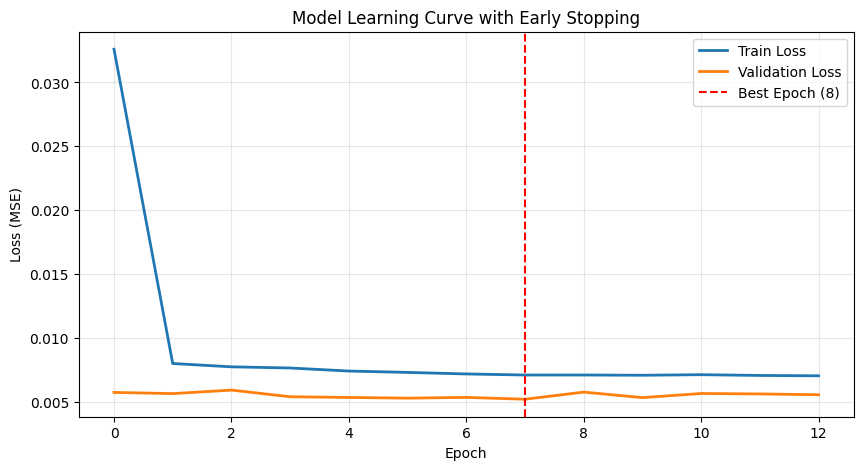


--- EVALUATION ON TEST SET ---
RMSE: 44.52
MSE:  1982.27
MAE:  33.83
MAPE: 26.94%


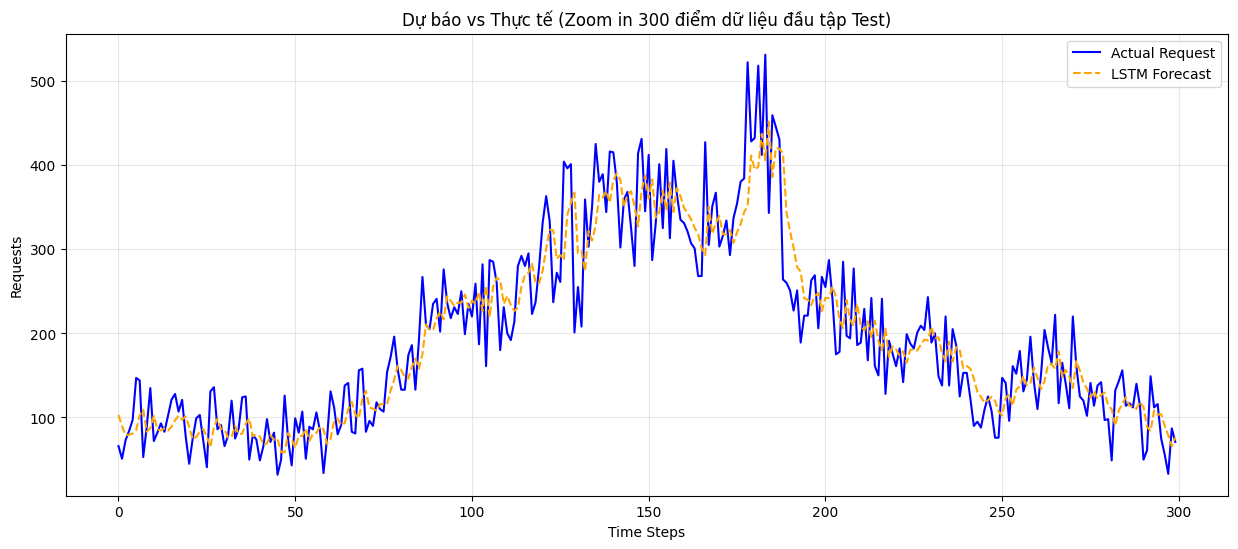

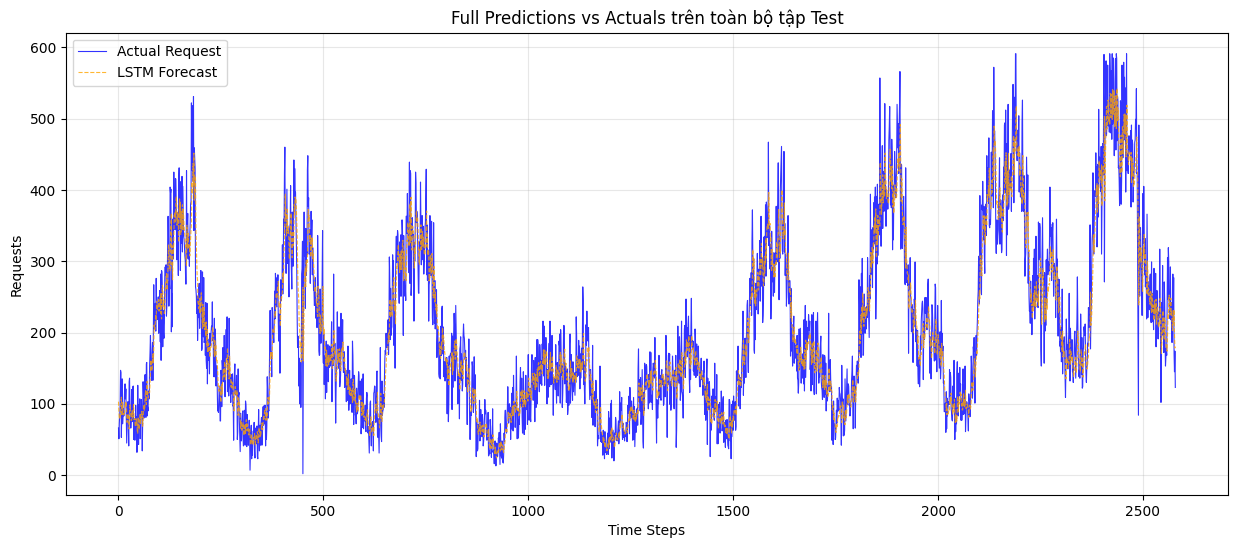

    ✓ Test MAPE: 26.94% | RMSE: 44.52

[2/7] Testing: medium_model | standard | seq_12
    Priority: high
Train size: 13248 | Validation size: 1728 | Test size: 2592
Patience: 5 epochs | Save path: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_medium_model_standard_seq_12.pth
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_medium_model_standard_seq_12.pth
Epoch [1/50] ✓ Best Model! Train Loss: 0.014266, Val Loss: 0.005716
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_medium_model_standard_seq_12.pth
Epoch [5/50] ✓ Best Model! Train Loss: 0.007513, Val Loss: 0.005509
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_medium_model_standard_seq_12.pth
Epoch [6/50] ✓ Best Model! Train Loss: 0.007457, Val Loss: 0.005334
Epoch [10/50] Train Loss: 0.007240, Val Loss: 0.006184 (Patience: 4/5)
Model weights saved to: D:\Documents\AutoScalin

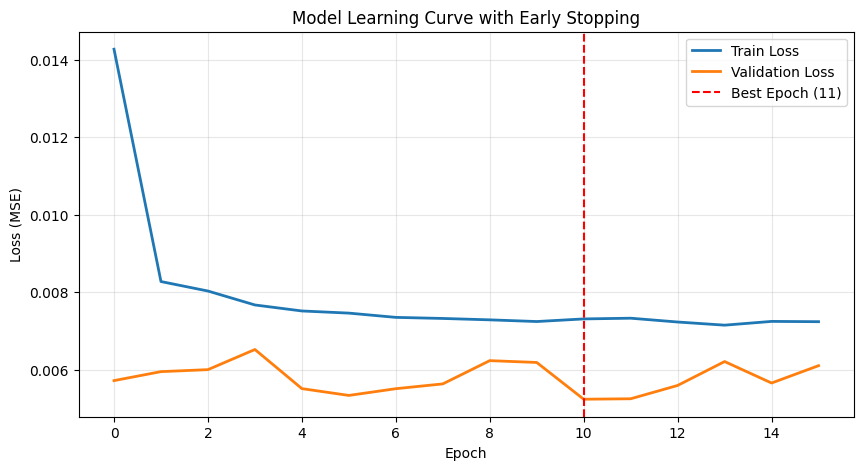


--- EVALUATION ON TEST SET ---
RMSE: 44.89
MSE:  2015.53
MAE:  34.09
MAPE: 27.16%


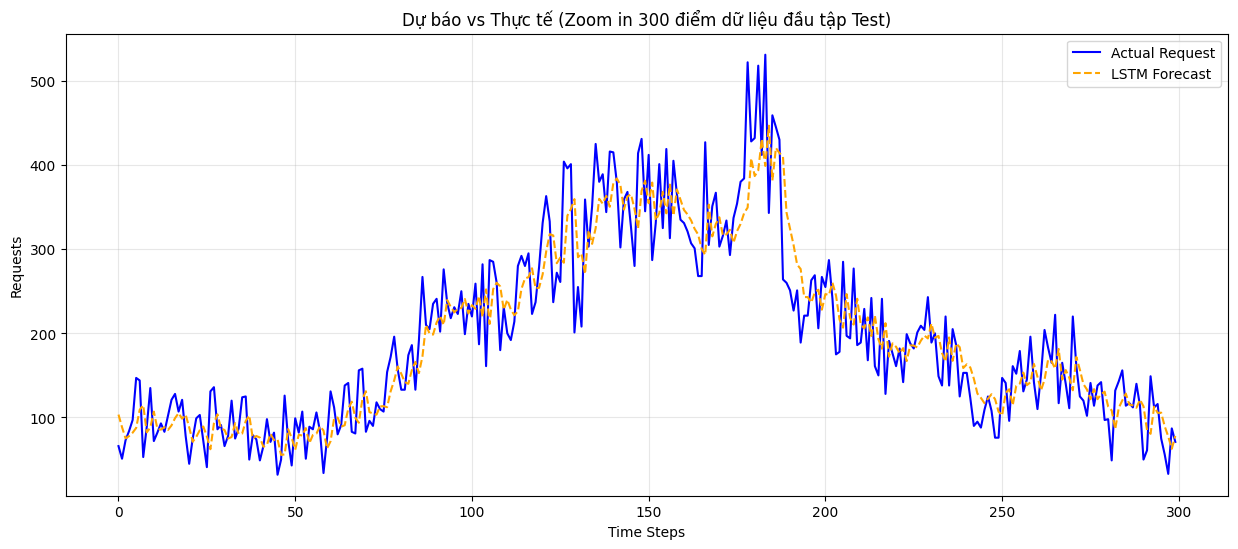

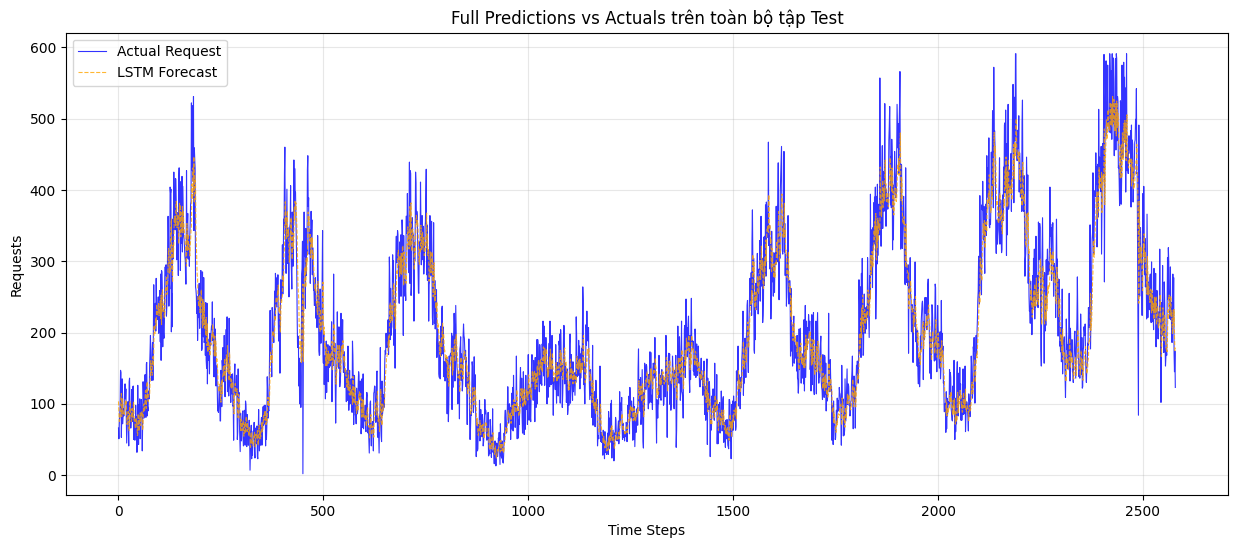

    ✓ Test MAPE: 27.16% | RMSE: 44.89

[3/7] Testing: large_model | standard | seq_12
    Priority: high
Train size: 13248 | Validation size: 1728 | Test size: 2592
Patience: 5 epochs | Save path: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_large_model_standard_seq_12.pth
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_large_model_standard_seq_12.pth
Epoch [1/50] ✓ Best Model! Train Loss: 0.013735, Val Loss: 0.007823
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_large_model_standard_seq_12.pth
Epoch [3/50] ✓ Best Model! Train Loss: 0.007917, Val Loss: 0.006980
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_large_model_standard_seq_12.pth
Epoch [4/50] ✓ Best Model! Train Loss: 0.007671, Val Loss: 0.005407
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_large_model_standard_seq_12.pt

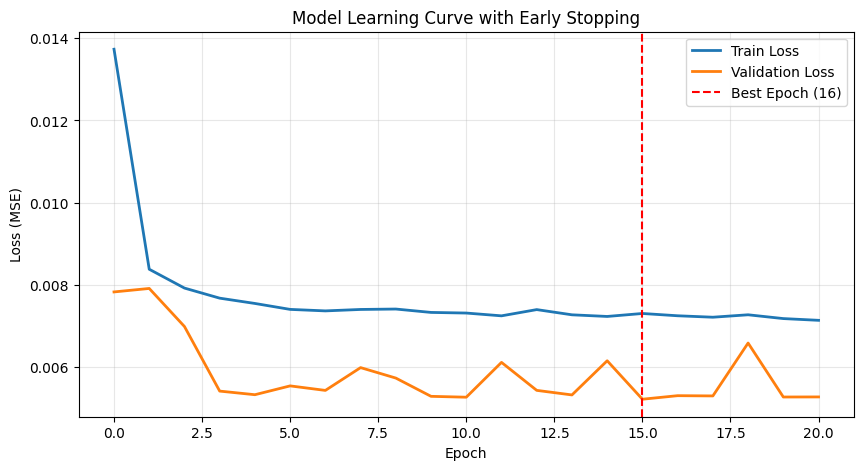


--- EVALUATION ON TEST SET ---
RMSE: 44.60
MSE:  1989.27
MAE:  33.87
MAPE: 27.60%


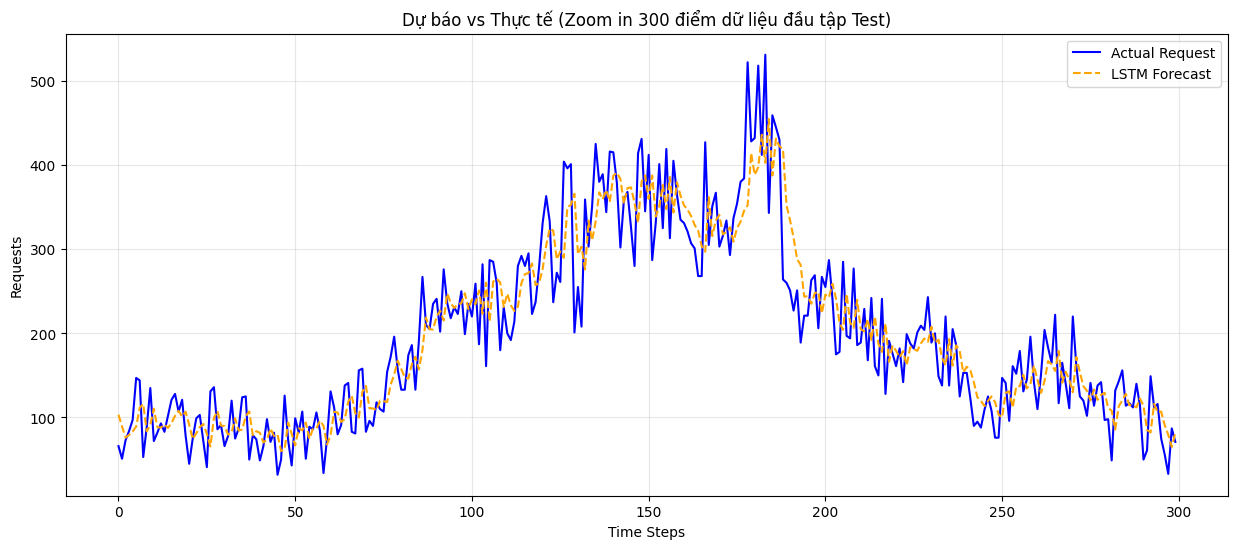

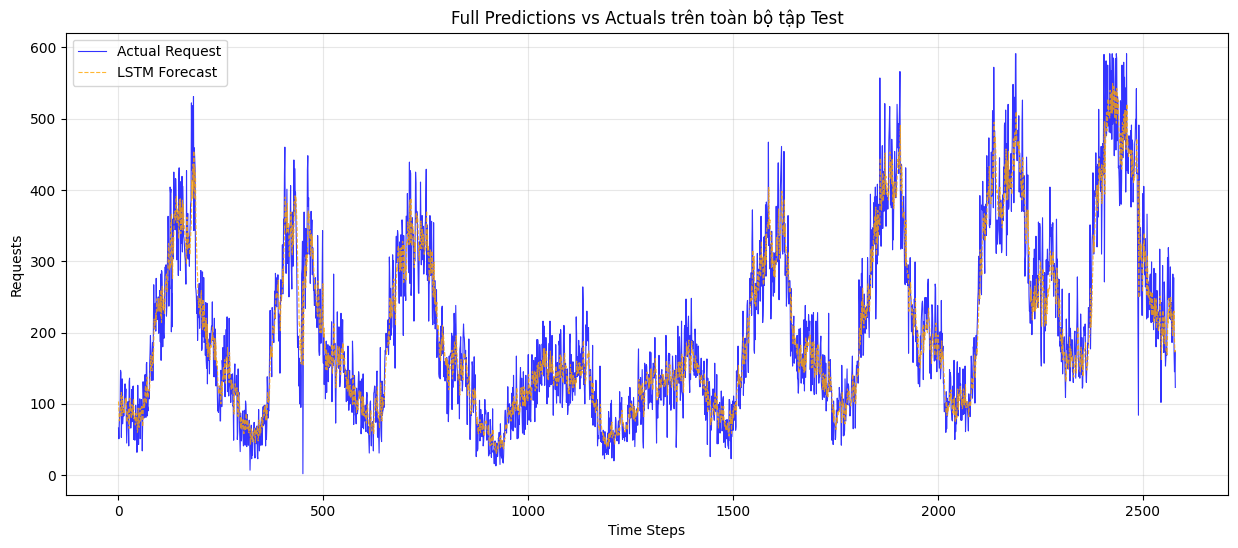

    ✓ Test MAPE: 27.60% | RMSE: 44.60

[4/7] Testing: medium_model | aggressive | seq_12
    Priority: medium
Train size: 13248 | Validation size: 1728 | Test size: 2592
Patience: 10 epochs | Save path: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_medium_model_aggressive_seq_12.pth
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_medium_model_aggressive_seq_12.pth
Epoch [1/100] ✓ Best Model! Train Loss: 0.010812, Val Loss: 0.005729
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_medium_model_aggressive_seq_12.pth
Epoch [2/100] ✓ Best Model! Train Loss: 0.008028, Val Loss: 0.005314
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_medium_model_aggressive_seq_12.pth
Epoch [5/100] ✓ Best Model! Train Loss: 0.007520, Val Loss: 0.005219
Epoch [10/100] Train Loss: 0.007295, Val Loss: 0.005422 (Patience: 5/10)
Model weights saved to: D:\Do

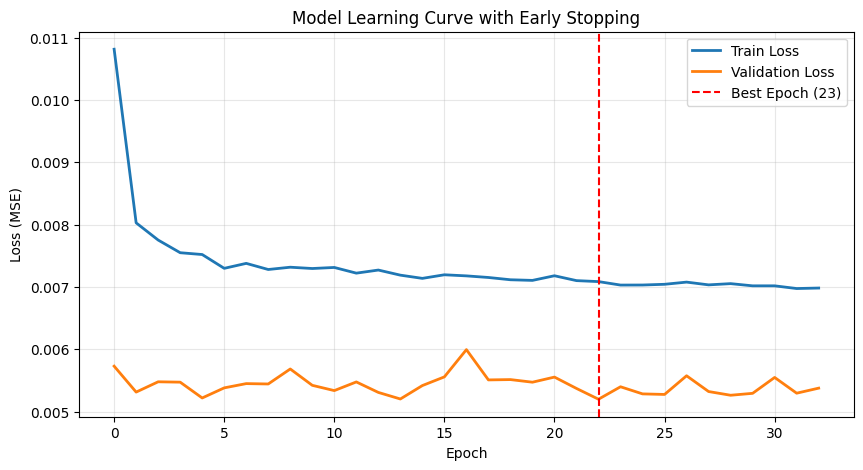


--- EVALUATION ON TEST SET ---
RMSE: 44.80
MSE:  2007.42
MAE:  33.93
MAPE: 27.22%


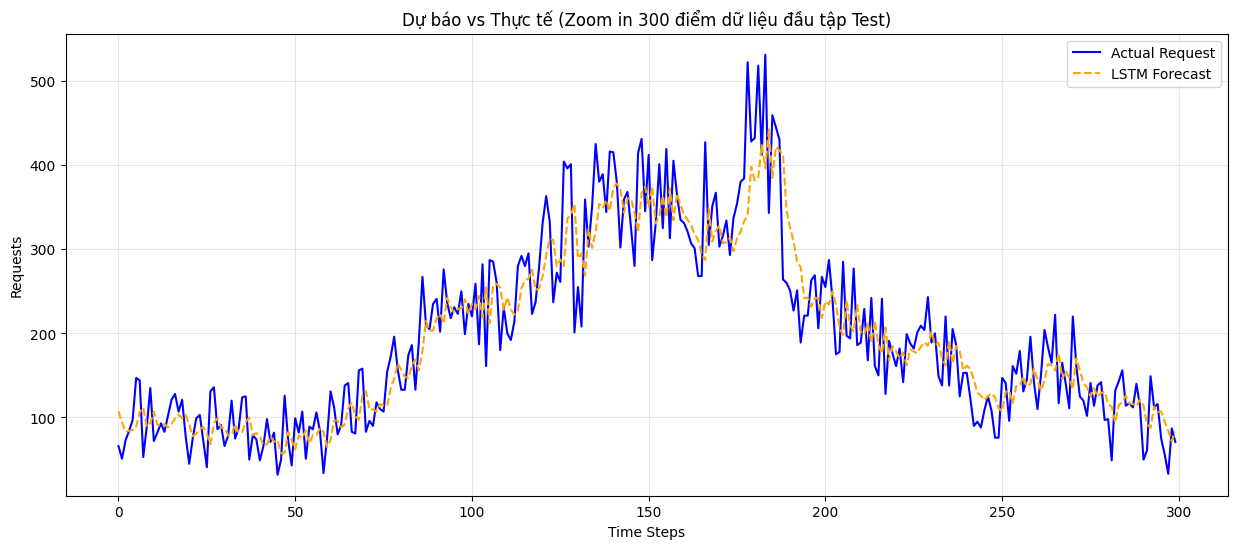

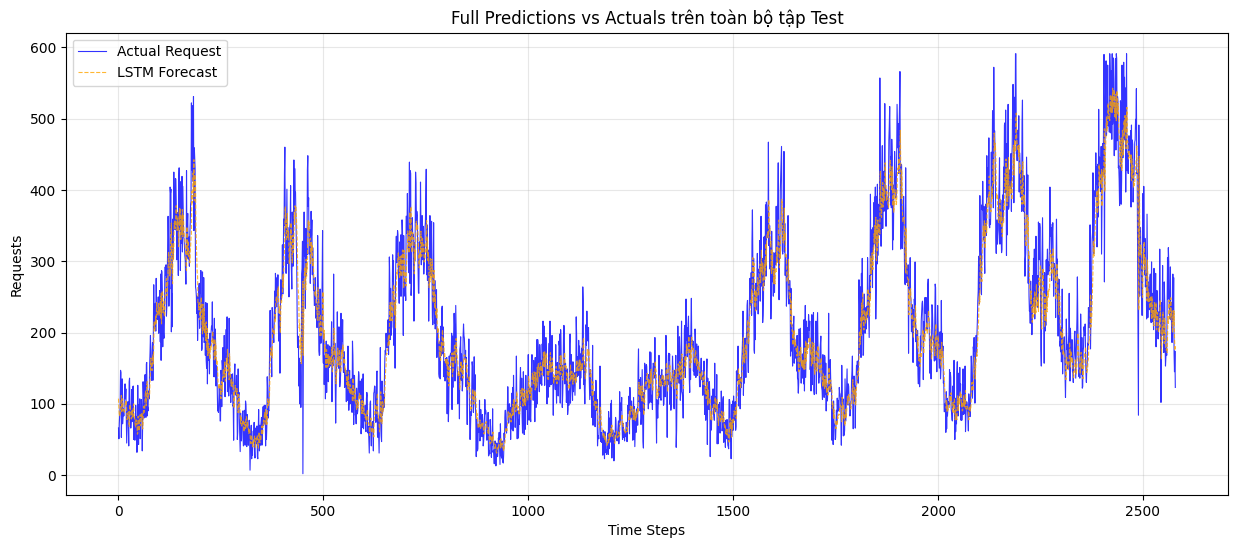

    ✓ Test MAPE: 27.22% | RMSE: 44.80

[5/7] Testing: medium_model | conservative | seq_12
    Priority: medium
Train size: 13248 | Validation size: 1728 | Test size: 2592
Patience: 5 epochs | Save path: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_medium_model_conservative_seq_12.pth
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_medium_model_conservative_seq_12.pth
Epoch [1/50] ✓ Best Model! Train Loss: 0.021609, Val Loss: 0.006061
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_medium_model_conservative_seq_12.pth
Epoch [5/50] ✓ Best Model! Train Loss: 0.008215, Val Loss: 0.005656
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_medium_model_conservative_seq_12.pth
Epoch [9/50] ✓ Best Model! Train Loss: 0.007739, Val Loss: 0.005618
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_med

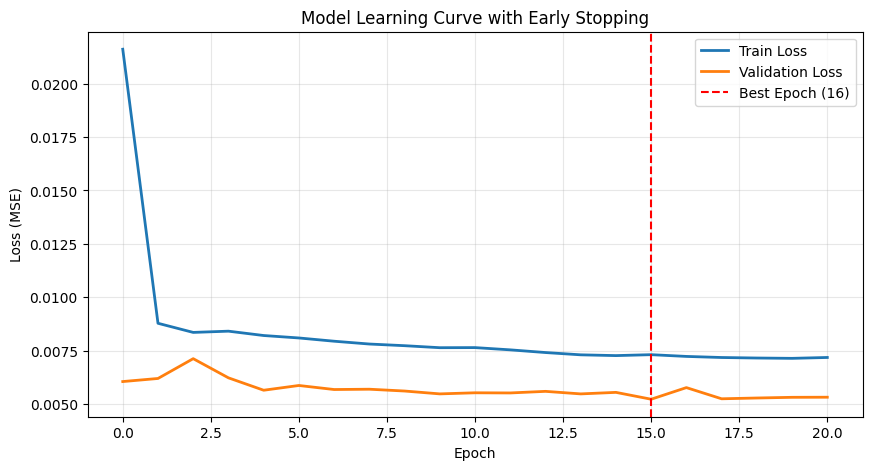


--- EVALUATION ON TEST SET ---
RMSE: 44.61
MSE:  1989.74
MAE:  34.00
MAPE: 28.17%


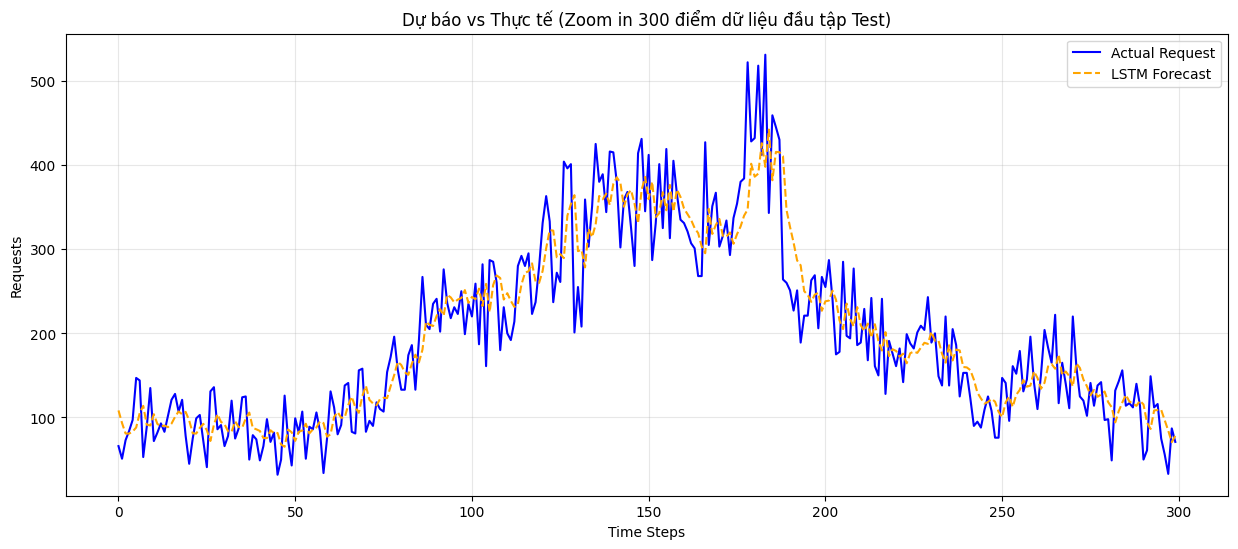

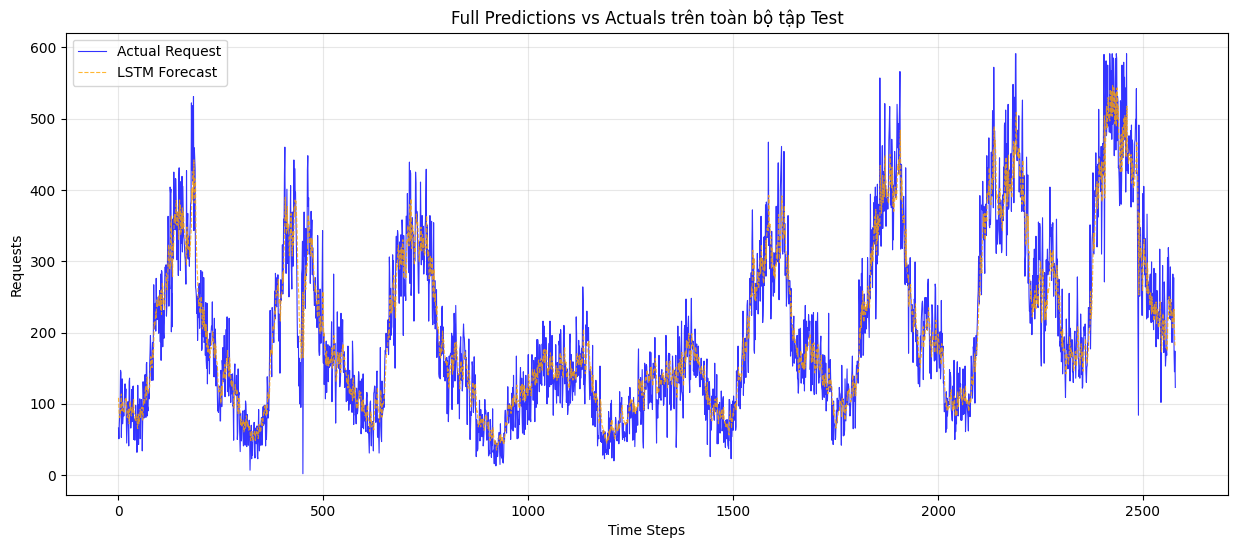

    ✓ Test MAPE: 28.17% | RMSE: 44.61

[6/7] Testing: medium_model | standard | seq_24
    Priority: medium
Train size: 13248 | Validation size: 1728 | Test size: 2592
Patience: 5 epochs | Save path: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_medium_model_standard_seq_24.pth
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_medium_model_standard_seq_24.pth
Epoch [1/50] ✓ Best Model! Train Loss: 0.015388, Val Loss: 0.006223
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_medium_model_standard_seq_24.pth
Epoch [2/50] ✓ Best Model! Train Loss: 0.008357, Val Loss: 0.005919
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_medium_model_standard_seq_24.pth
Epoch [4/50] ✓ Best Model! Train Loss: 0.007781, Val Loss: 0.005752
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_medium_model_standard_s

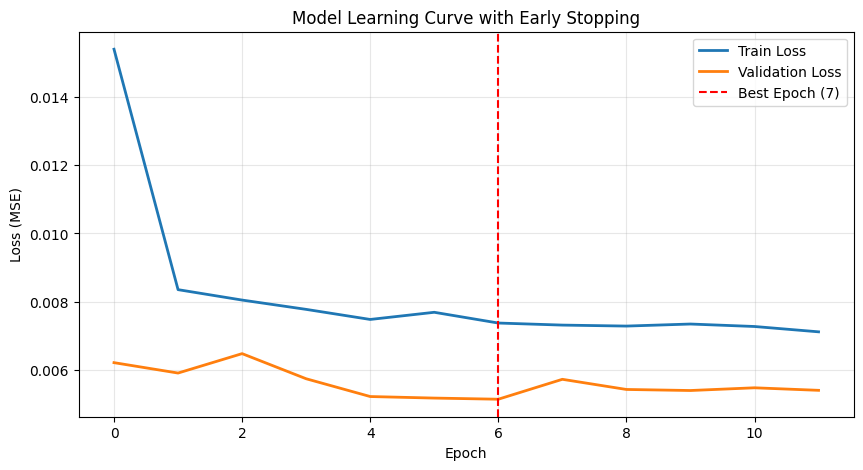


--- EVALUATION ON TEST SET ---
RMSE: 44.93
MSE:  2018.97
MAE:  34.15
MAPE: 27.77%


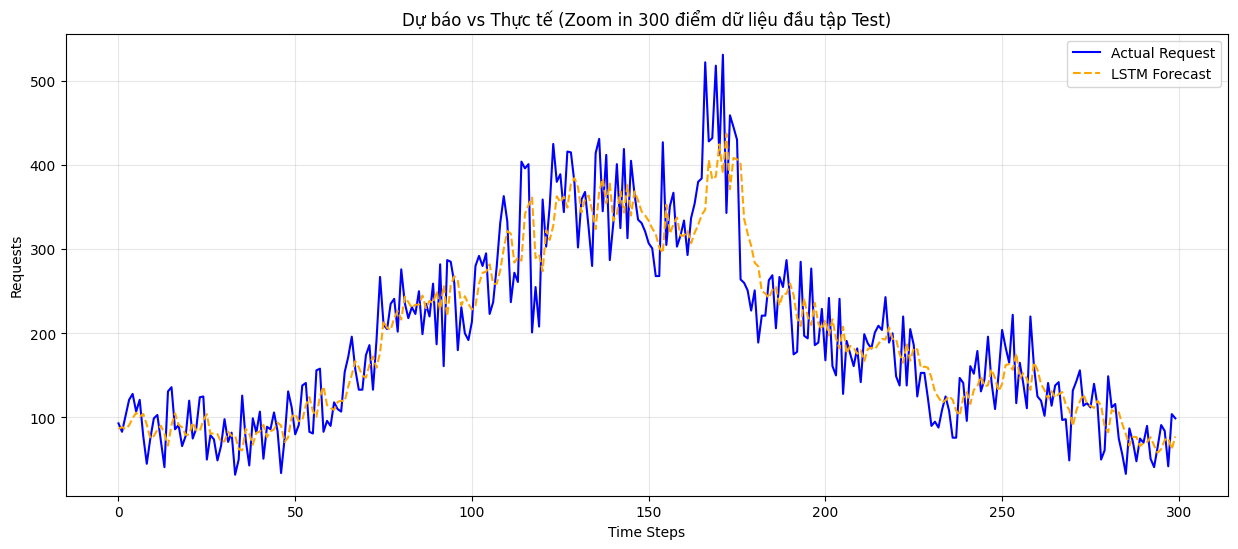

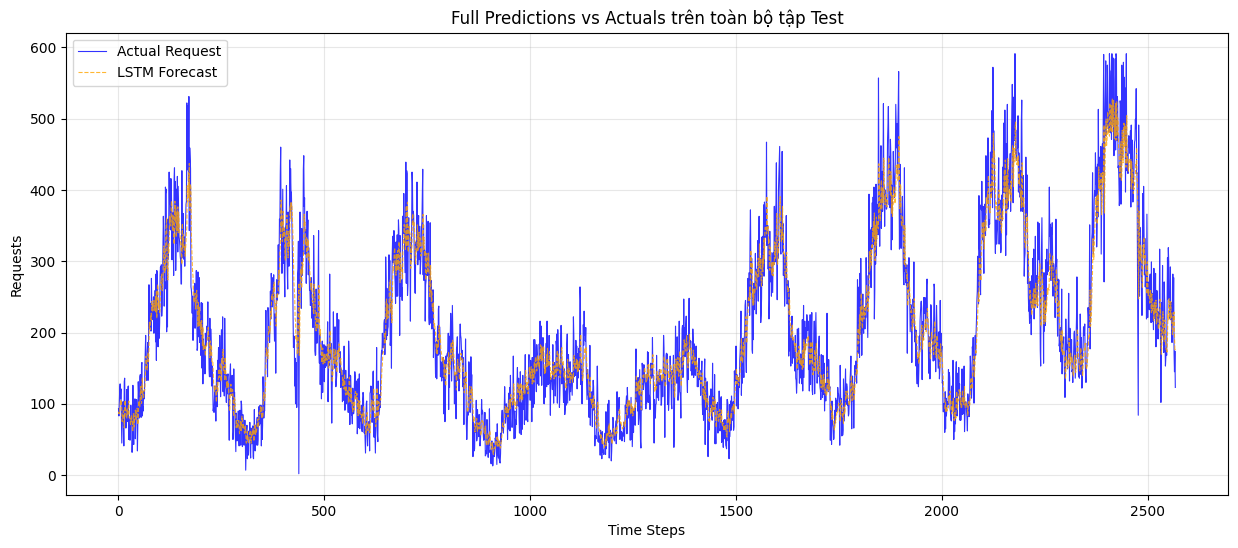

    ✓ Test MAPE: 27.77% | RMSE: 44.93

[7/7] Testing: deep_model | standard | seq_12
    Priority: low
Train size: 13248 | Validation size: 1728 | Test size: 2592
Patience: 5 epochs | Save path: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_deep_model_standard_seq_12.pth
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_deep_model_standard_seq_12.pth
Epoch [1/50] ✓ Best Model! Train Loss: 0.012605, Val Loss: 0.006025
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_deep_model_standard_seq_12.pth
Epoch [2/50] ✓ Best Model! Train Loss: 0.008510, Val Loss: 0.005970
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_deep_model_standard_seq_12.pth
Epoch [3/50] ✓ Best Model! Train Loss: 0.008142, Val Loss: 0.005744
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\tuning_deep_model_standard_seq_12.pth
Epoch

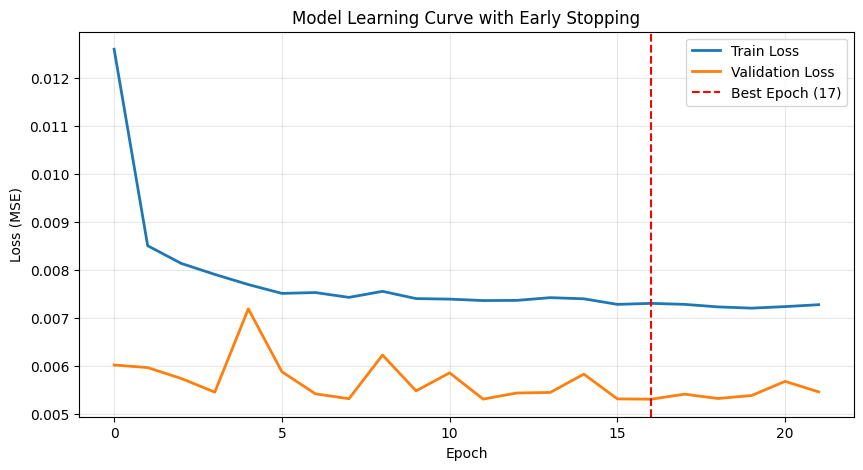


--- EVALUATION ON TEST SET ---
RMSE: 46.17
MSE:  2131.27
MAE:  34.67
MAPE: 27.11%


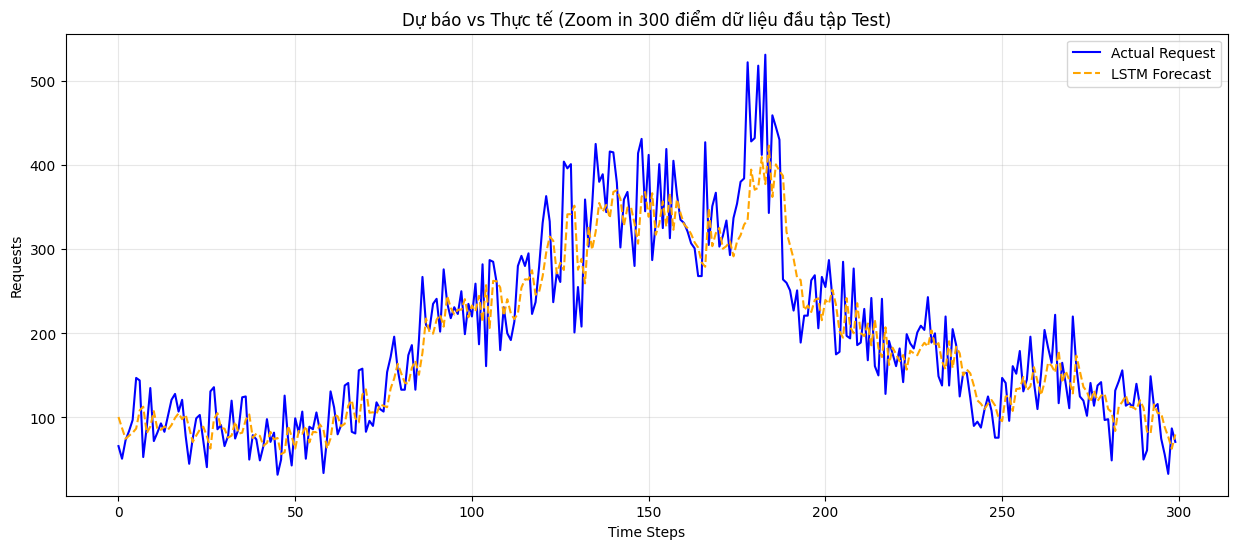

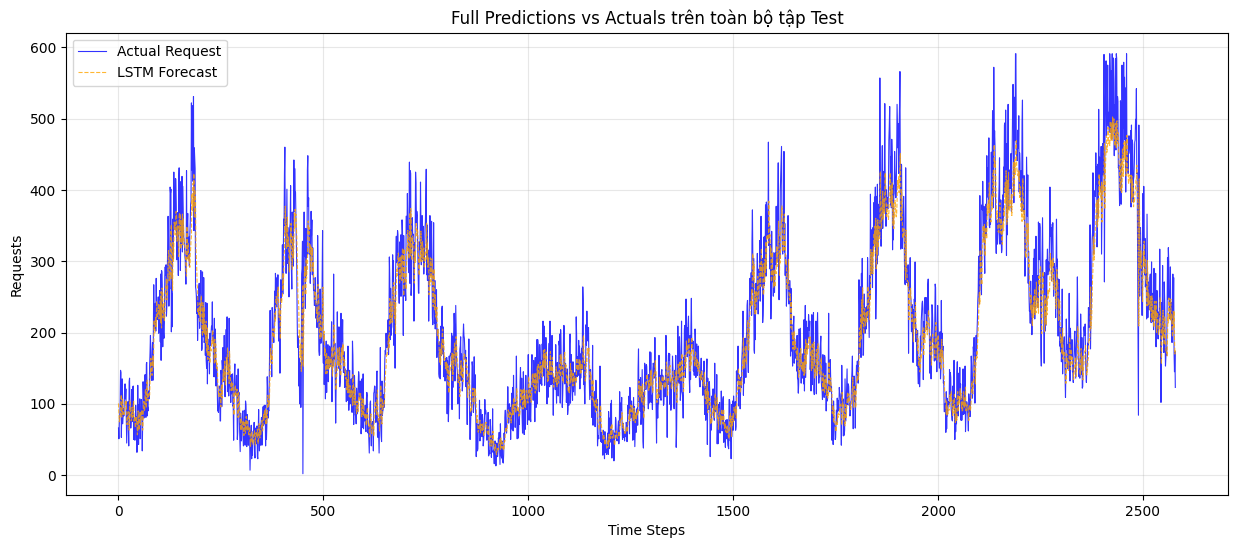

    ✓ Test MAPE: 27.11% | RMSE: 46.17

TUNING RESULTS SUMMARY
       model     training   data  test_rmse  test_mae  test_mape
 small_model     standard seq_12  44.522710 33.831947  26.936310
medium_model     standard seq_12  44.894709 34.090450  27.156910
 large_model     standard seq_12  44.601211 33.873543  27.599897
medium_model   aggressive seq_12  44.804254 33.931759  27.224339
medium_model conservative seq_12  44.606496 34.001034  28.173622
medium_model     standard seq_24  44.932971 34.150585  27.768221
  deep_model     standard seq_12  46.165643 34.674480  27.112747

🏆 Best Configuration:
   Model: small_model
   Training: standard
   Data: seq_12
   Test MAPE: 26.94%
   Test RMSE: 44.52


In [ ]:
tuning_results = run_hyperparameter_tuning(config, scaler_target, scaler_features, df_lstm_input)



📊 Top 5 Best Configurations:
       model   training   data  test_rmse  test_mape
 small_model   standard seq_12  44.522710  26.936310
  deep_model   standard seq_12  46.165643  27.112747
medium_model   standard seq_12  44.894709  27.156910
medium_model aggressive seq_12  44.804254  27.224339
 large_model   standard seq_12  44.601211  27.599897


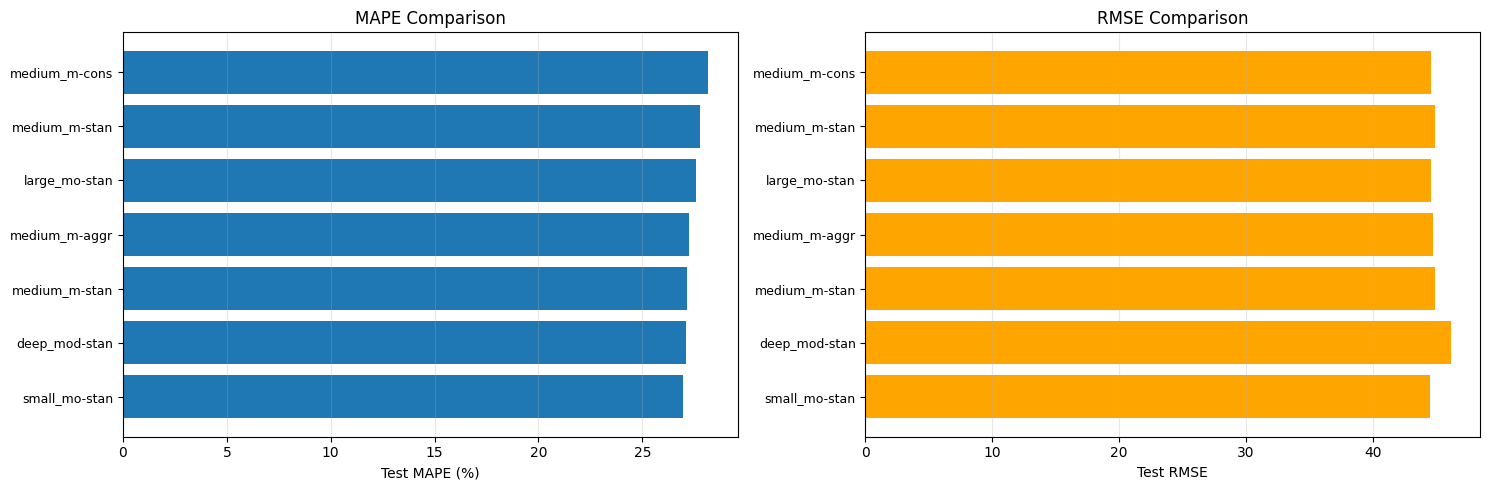

In [48]:
results_sorted = tuning_results['results_df'].sort_values('test_mape')

print("\n📊 Top 5 Best Configurations:")
print(results_sorted[['model', 'training', 'data', 'test_rmse', 'test_mape']].head(5).to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# MAPE comparison
axes[0].barh(range(len(results_sorted)), results_sorted['test_mape'].values)
axes[0].set_yticks(range(len(results_sorted)))
axes[0].set_yticklabels([f"{row['model'][:8]}-{row['training'][:4]}" for _, row in results_sorted.iterrows()], fontsize=9)
axes[0].set_xlabel('Test MAPE (%)')
axes[0].set_title('MAPE Comparison')
axes[0].grid(axis='x', alpha=0.3)

# RMSE comparison
axes[1].barh(range(len(results_sorted)), results_sorted['test_rmse'].values, color='orange')
axes[1].set_yticks(range(len(results_sorted)))
axes[1].set_yticklabels([f"{row['model'][:8]}-{row['training'][:4]}" for _, row in results_sorted.iterrows()], fontsize=9)
axes[1].set_xlabel('Test RMSE')
axes[1].set_title('RMSE Comparison')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


In [76]:
# Sau khi tuning chọn model small tốt nhất và train lại
model = LSTMModel(
    input_size=5,           # 5 features: requests_target, error_rate, hour_sin, hour_cos, is_weekend
    hidden_size=32,
    num_layers=1,
    dropout=0.1
)
model = model.to(device)

print(f"Model Architecture:\n{model}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


Model Architecture:
LSTMModel(
  (lstm): LSTM(5, 32, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
Total parameters: 5,025


d:\Documents\AutoScaling Analysis\Autoscaling-Analysis\venv\lib\site-packages\torch\nn\modules\rnn.py:990: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  super().__init__("LSTM", *args, **kwargs)


Patience: 10 epochs | Save path: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\lstm_5m_best_model.pth
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\lstm_5m_best_model.pth
Epoch [1/50] ✓ Best Model! Train Loss: 0.019845, Val Loss: 0.005858
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\lstm_5m_best_model.pth
Epoch [2/50] ✓ Best Model! Train Loss: 0.007726, Val Loss: 0.005856
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\lstm_5m_best_model.pth
Epoch [3/50] ✓ Best Model! Train Loss: 0.007510, Val Loss: 0.005540
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\lstm_5m_best_model.pth
Epoch [5/50] ✓ Best Model! Train Loss: 0.007171, Val Loss: 0.005284
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\lstm_5m_best_model.pth
Epoch [8/50] ✓ Best Model! Train Loss: 0.007070, Val Loss: 0.0052

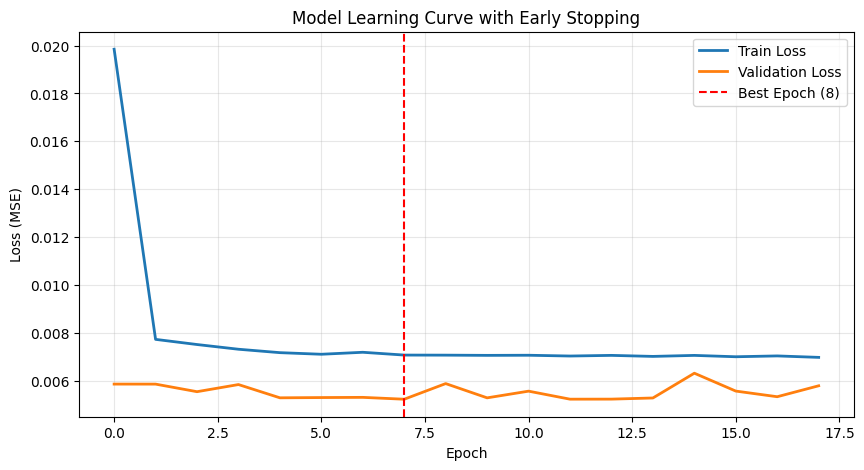


✓ Training completed!
Best Epoch: 8
Best Validation Loss: 0.005225


In [77]:
model_save_path = MODELS_DIR / 'lstm_5m_best_model.pth'

train_result = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=50,
    lr=0.001,
    patience=10,
    model_save_path=model_save_path
)

print(f"\n✓ Training completed!")
print(f"Best Epoch: {train_result['best_epoch']}")
print(f"Best Validation Loss: {train_result['best_val_loss']:.6f}")



--- EVALUATION ON TEST SET ---
RMSE: 44.59
MSE:  1988.35
MAE:  33.86
MAPE: 26.91%


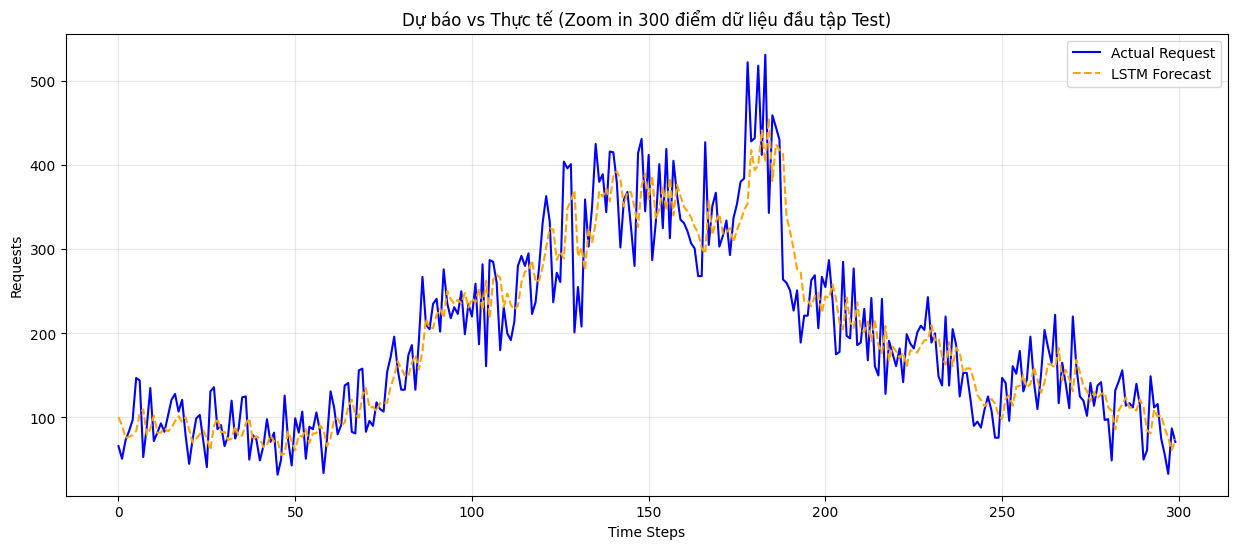

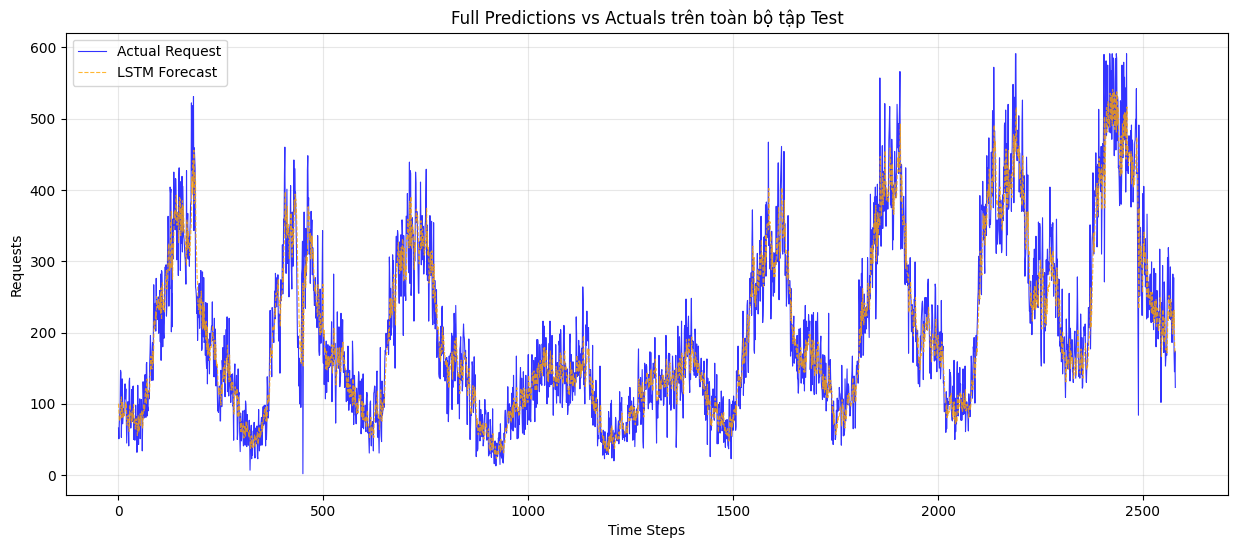


✓ Evaluation completed!

Test Set Metrics:
  RMSE: 44.59
  MAE:  33.86
  MAPE: 26.91%


In [51]:
eval_result = evaluate(
    model=train_result['model'],
    test_loader=test_loader,
    scaler_target=scaler_target
)

print(f"\n✓ Evaluation completed!")
print(f"\nTest Set Metrics:")
print(f"  RMSE: {eval_result['metrics']['rmse']:.2f}")
print(f"  MAE:  {eval_result['metrics']['mae']:.2f}")
print(f"  MAPE: {eval_result['metrics']['mape']:.2f}%")


In [79]:
import json
from datetime import datetime

# Create results summary
results_summary = {
    'timestamp': datetime.now().isoformat(),
    'model_config': {
        'input_size': 5,
        'hidden_size': 64,
        'num_layers': 2,
        'dropout': 0.2
    },
    'training_config': {
        'epochs': 50,
        'batch_size': 32,
        'learning_rate': 0.001,
        'patience': 5,
        'sequence_length': 12
    },
    'training_results': {
        'best_epoch': train_result['best_epoch'],
        'best_val_loss': float(train_result['best_val_loss']),
        'num_epochs_trained': len(train_result['train_losses'])
    },
    'test_metrics': {
        'rmse': float(eval_result['metrics']['rmse']),
        'mse': float(eval_result['metrics']['mse']),
        'mae': float(eval_result['metrics']['mae']),
        'mape': float(eval_result['metrics']['mape'])
    }
}

# Save to JSON
results_path = OUTPUT_DIR / 'lstm_5m_results.json'
with open(results_path, 'w') as f:
    json.dump(results_summary, f, indent=4)

print(f"✓ Results saved to: {results_path}")
print(f"\nFinal Summary:")
print(json.dumps(results_summary, indent=2))


✓ Results saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\output\lstm_5m_results.json

Final Summary:
{
  "timestamp": "2026-02-03T17:28:25.969803",
  "model_config": {
    "input_size": 5,
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0.2
  },
  "training_config": {
    "epochs": 50,
    "batch_size": 32,
    "learning_rate": 0.001,
    "patience": 5,
    "sequence_length": 12
  },
  "training_results": {
    "best_epoch": 8,
    "best_val_loss": 0.005225474108657282,
    "num_epochs_trained": 18
  },
  "test_metrics": {
    "rmse": 44.59093724704957,
    "mse": 1988.3516845703125,
    "mae": 33.862876892089844,
    "mape": 26.913394927978516
  }
}


In [80]:
# ===========================
# MODEL PERSISTENCE & PRODUCTION UTILITIES
# ===========================
import pickle
from pathlib import Path

def save_scalers(scaler_features, scaler_target, output_dir=None):
    """
    Parameters:
    -----------
    scaler_features : MinMaxScaler
        Scaler cho input features
    scaler_target : MinMaxScaler
        Scaler cho target variable (requests_target)
    output_dir : Path
        Thư mục để lưu files (default: MODELS_DIR)
        
    Returns:
    --------
    dict : Paths đến hai scaler files
    """
    output_dir = Path(output_dir)
    
    # Lưu scaler cho features
    features_scaler_path = output_dir / 'scaler_features_5m.pkl'
    with open(features_scaler_path, 'wb') as f:
        pickle.dump(scaler_features, f)
    print(f"✓ Features scaler saved: {features_scaler_path}")
    
    # Lưu scaler cho target
    target_scaler_path = output_dir / 'scaler_target_5m.pkl'
    with open(target_scaler_path, 'wb') as f:
        pickle.dump(scaler_target, f)
    print(f"✓ Target scaler saved: {target_scaler_path}")
    
    return {
        'features_scaler_path': features_scaler_path,
        'target_scaler_path': target_scaler_path
    }


def load_scalers(features_scaler_path, target_scaler_path):
    with open(features_scaler_path, 'rb') as f:
        scaler_features = pickle.load(f)
    
    with open(target_scaler_path, 'rb') as f:
        scaler_target = pickle.load(f)
    
    print(f"✓ Scalers loaded successfully")
    return scaler_features, scaler_target


In [81]:
def save_model_metadata(model, scaler_features, scaler_target, eval_result, 
                       model_path=None, metadata_path=None):
    """
    Lưu model architecture, hyperparameters, scalers info, và performance metrics
    vào JSON file để sử dụng trong production
    
    Parameters:
    -----------
    model : LSTMModel
        Trained model
    scaler_features : MinMaxScaler
        Features scaler
    scaler_target : MinMaxScaler
        Target scaler
    eval_result : dict
        Kết quả evaluation (từ hàm evaluate)
    model_path : str or Path
        Path đến model weights
    metadata_path : str or Path
        Path để lưu metadata JSON (default: OUTPUT_DIR/model_metadata.json)
        
    Returns:
    --------
    dict : Metadata dictionary
    """
    if metadata_path is None:
        metadata_path = OUTPUT_DIR / 'model_metadata.json'
    
    metadata_path = Path(metadata_path)
    
    # Extract model architecture từ model object
    model_arch = {
        'input_size': model.lstm.input_size,
        'hidden_size': model.hidden_size,
        'num_layers': model.num_layers,
        'output_size': 1
    }
    
    # Scaler info
    scaler_info = {
        'features': {
            'feature_range': list(scaler_features.feature_range),
            'data_min': scaler_features.data_min_.tolist(),
            'data_max': scaler_features.data_max_.tolist()
        },
        'target': {
            'feature_range': list(scaler_target.feature_range),
            'data_min': scaler_target.data_min_.tolist() if hasattr(scaler_target.data_min_, 'tolist') else scaler_target.data_min_.item(),
            'data_max': scaler_target.data_max_.tolist() if hasattr(scaler_target.data_max_, 'tolist') else scaler_target.data_max_.item()
        }
    }
    
    # Metadata dictionary
    metadata = {
        'timestamp': datetime.now().isoformat(),
        'model_name': 'lstm_5m_best_model',
        'frequency': '5m',
        'model_architecture': model_arch,
        'model_weights_path': str(model_path) if model_path else 'lstm_5m_best_model.pth',
        'training_config': {
            'sequence_length': 12,
            'batch_size': 32,
            'learning_rate': 0.001,
            'epochs': 50,
            'patience': 10
        },
        'features': ['requests_target', 'error_rate', 'hour_sin', 'hour_cos', 'is_weekend'],
        'feature_count': 5,
        'scaler_info': scaler_info,
        'evaluation_metrics': {
            'rmse': float(eval_result['metrics']['rmse']),
            'mae': float(eval_result['metrics']['mae']),
            'mape': float(eval_result['metrics']['mape']),
            'mse': float(eval_result['metrics']['mse'])
        },
        'inference_config': {
            'sequence_length': 12,
            'expected_input_shape': [None, 12, 5],
            'output_shape': [None, 1],
            'device': 'cpu'  # For inference, use CPU
        }
    }
    
    # Lưu metadata vào JSON
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)
    
    print(f"✓ Model metadata saved: {metadata_path}")
    return metadata


In [82]:
def load_production_model(model_weights_path, metadata_path=None):
    model_weights_path = Path(model_weights_path)
    
    # Load metadata để biết architecture
    if metadata_path is None:
        metadata_path = OUTPUT_DIR / 'model_metadata.json'
    
    metadata_path = Path(metadata_path)
    
    if not metadata_path.exists():
        raise FileNotFoundError(f"Metadata file not found: {metadata_path}")
    
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    # Reconstruct model architecture từ metadata
    arch = metadata['model_architecture']
    model = LSTMModel(
        input_size=arch['input_size'],
        hidden_size=arch['hidden_size'],
        num_layers=arch['num_layers'],
        dropout=0.2
    )
    
    # Load weights
    model = load_model_weights(model, model_weights_path)
    model.eval()  # Set to evaluation mode
    
    print(f"✓ Production model loaded successfully")
    print(f"  Architecture: {arch['input_size']} → {arch['hidden_size']}×{arch['num_layers']} → {arch['output_size']}")
    print(f"  Metrics: MAPE={metadata['evaluation_metrics']['mape']:.2f}%, RMSE={metadata['evaluation_metrics']['rmse']:.2f}")
    
    return model, metadata


In [83]:
def validate_real_time_input(data_dict, expected_features):
    """
    Validate real-time data trước khi đưa vào model
    
    Parameters:
    -----------
    data_dict : dict
        Dữ liệu real-time với format:
        {
            'requests_target': [float, ...],  # 12 values (60 min, 5m interval)
            'error_rate': [float, ...],
            'hour_sin': [float, ...],
            'hour_cos': [float, ...],
            'is_weekend': [float, ...]
        }
    expected_features : list
        Danh sách features cần có
        
    Returns:
    --------
    tuple : (is_valid: bool, error_message: str or None)
    """
    # Check all features present
    missing_features = [f for f in expected_features if f not in data_dict]
    if missing_features:
        return False, f"Missing features: {missing_features}"
    
    # Check length of sequences
    for feature, values in data_dict.items():
        if feature in expected_features:
            if not isinstance(values, (list, tuple, np.ndarray)):
                return False, f"Feature {feature} must be list/array, got {type(values)}"
            if len(values) != 12:
                return False, f"Feature {feature} should have 12 values, got {len(values)}"
            
            # Check for NaN/Inf
            if np.any(np.isnan(values)) or np.any(np.isinf(values)):
                return False, f"Feature {feature} contains NaN or Inf values"
    
    return True, None


def real_time_predict(model, scaler_features, scaler_target, data_dict, 
                     expected_features, metadata=None, return_confidence=False):
    """
    Thực hiện prediction trên real-time data
    
    Parameters:
    -----------
    model : LSTMModel
        Trained model (set to eval mode)
    scaler_features : MinMaxScaler
        Features scaler (phải fit trên training data)
    scaler_target : MinMaxScaler
        Target scaler
    data_dict : dict
        Real-time data với cấu trúc:
        {
            'requests_target': [values...],
            'error_rate': [values...],
            'hour_sin': [values...],
            'hour_cos': [values...],
            'is_weekend': [values...]
        }
    expected_features : list
        Danh sách features trong đúng thứ tự
    metadata : dict
        Model metadata (optional, for logging)
    return_confidence : bool
        Nếu True, return thêm uncertainty estimate (default: False)
        
    Returns:
    --------
    dict : {
        'prediction': float,  # Dự báo số requests (unscaled)
        'prediction_scaled': float,  # Dự báo scaled [0,1]
        'timestamp': str,
        'confidence_interval': tuple (lower, upper) if return_confidence else None
    }
    """
    # 1. Validation
    is_valid, error_msg = validate_real_time_input(data_dict, expected_features)
    if not is_valid:
        raise ValueError(f"Input validation failed: {error_msg}")
    
    # 2. Prepare input array
    input_array = np.array([
        data_dict[feature] for feature in expected_features
    ]).T  # Shape: (12, 5)
    
    # 3. Normalize using training scalers
    input_scaled = scaler_features.transform(input_array)
    
    # 4. Convert to tensor
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32).unsqueeze(0).to(device)
    # Shape: (1, 12, 5) - batch_size=1
    
    # 5. Model prediction
    with torch.no_grad():
        output_scaled = model(input_tensor)
        output_scaled = output_scaled.squeeze().cpu().numpy()
    
    # 6. Inverse transform
    output_unscaled = scaler_target.inverse_transform([[output_scaled]])[0][0]
    
    # 7. Prepare result
    result = {
        'prediction': float(output_unscaled),
        'prediction_scaled': float(output_scaled),
        'timestamp': datetime.now().isoformat(),
        'confidence_interval': None
    }
    
    # 8. Optional: Estimate confidence (简单的基于scaler range的估计)
    if return_confidence:
        # Simple confidence: ±10% based on MAPE from training
        if metadata:
            mape = metadata['evaluation_metrics']['mape']
        else:
            mape = 18.2  # Default from training
        
        margin = output_unscaled * (mape / 100.0)
        result['confidence_interval'] = (
            float(output_unscaled - margin),
            float(output_unscaled + margin)
        )
    
    return result


In [84]:
def create_data_buffer(df, frequency='5m', window_size=12):
    """
    Tạo sliding window buffer từ dataframe cho real-time prediction
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame với columns: ['requests_target', 'error_rate', 'hour_sin', 'hour_cos', 'is_weekend']
        Index phải là datetime
    frequency : str
        Frequency của dữ liệu ('1m', '5m', '15m', etc)
    window_size : int
        Kích thước window (default: 12 cho 5m data = 60 min)
        
    Returns:
    --------
    dict : Sliding window buffer
    """
    required_cols = ['requests_target', 'error_rate', 'hour_sin', 'hour_cos', 'is_weekend']
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")
    
    buffer = {
        'data': df[required_cols].tail(window_size).values,  # Shape: (12, 5)
        'features': required_cols,
        'timestamp': df.index[-1],
        'frequency': frequency,
        'window_size': window_size
    }
    
    return buffer


def update_buffer(buffer, new_row_dict):
    """
    Update buffer với row mới (sliding window)
    
    Parameters:
    -----------
    buffer : dict
        Buffer từ create_data_buffer
    new_row_dict : dict
        Row mới với format: {'requests_target': val, 'error_rate': val, ...}
        
    Returns:
    --------
    dict : Updated buffer
    """
    features = buffer['features']
    new_values = np.array([new_row_dict[f] for f in features])
    
    # Remove oldest, add newest
    buffer['data'] = np.vstack([buffer['data'][1:], new_values])
    buffer['timestamp'] = datetime.now()
    
    return buffer


def export_model_and_scalers_for_api(model_path, scaler_features, scaler_target, metadata,
                                     export_dir='./models_export'):
    """
    Export model + scalers + metadata vào một package hoàn chỉnh
    để dùng trong API production
    
    Parameters:
    -----------
    model_path : Path
        Path đến .pth file
    scaler_features : MinMaxScaler
    scaler_target : MinMaxScaler
    metadata : dict
    export_dir : str
        Thư mục export
        
    Returns:
    --------
    dict : Package info
    """
    export_path = Path(export_dir)
    export_path.mkdir(parents=True, exist_ok=True)
    
    # Copy model weights
    import shutil
    model_dest = export_path / 'model_weights.pth'
    shutil.copy(str(model_path), str(model_dest))
    print(f"✓ Model weights: {model_dest}")
    
    # Save scalers
    features_scaler_dest = export_path / 'scaler_features.pkl'
    target_scaler_dest = export_path / 'scaler_target.pkl'
    
    with open(features_scaler_dest, 'wb') as f:
        pickle.dump(scaler_features, f)
    print(f"✓ Features scaler: {features_scaler_dest}")
    
    with open(target_scaler_dest, 'wb') as f:
        pickle.dump(scaler_target, f)
    print(f"✓ Target scaler: {target_scaler_dest}")
    
    # Save metadata
    metadata_dest = export_path / 'model_metadata.json'
    with open(metadata_dest, 'w') as f:
        json.dump(metadata, f, indent=4)
    print(f"✓ Metadata: {metadata_dest}")
    
    # Create requirements.txt for API
    requirements = """torch==2.0.0
numpy==1.24.0
pandas==2.0.0
scikit-learn==1.3.0"""
    
    req_dest = export_path / 'requirements.txt'
    with open(req_dest, 'w') as f:
        f.write(requirements)
    print(f"✓ Requirements: {req_dest}")
    
    # Create a README
    readme = """# LSTM Model Package

## Files:
- model_weights.pth: PyTorch model weights
- scaler_features.pkl: Features normalization scaler
- scaler_target.pkl: Target denormalization scaler
- model_metadata.json: Architecture & hyperparameters

## Usage:
```python
import torch
import pickle
import json
import numpy as np

# Load model
model = LSTMModel(...)
model.load_state_dict(torch.load('model_weights.pth'))

# Load scalers
with open('scaler_features.pkl', 'rb') as f:
    scaler_features = pickle.load(f)
with open('scaler_target.pkl', 'rb') as f:
    scaler_target = pickle.load(f)

# Prediction
input_dict = {
    'requests_target': [vals...],  # 12 values
    'error_rate': [vals...],
    ...
}
result = real_time_predict(model, scaler_features, scaler_target, input_dict)
```
"""
    
    readme_dest = export_path / 'README.md'
    with open(readme_dest, 'w') as f:
        f.write(readme)
    print(f"✓ README: {readme_dest}")
    
    package_info = {
        'export_dir': str(export_path),
        'files': {
            'model_weights': str(model_dest),
            'scaler_features': str(features_scaler_dest),
            'scaler_target': str(target_scaler_dest),
            'metadata': str(metadata_dest),
            'requirements': str(req_dest),
            'readme': str(readme_dest)
        }
    }
    
    print(f"\n✓ Model package exported to: {export_path}")
    return package_info


## Summary: Production Model Artifacts

### Files Generated by Notebook:
1. **Model Weights**: `models/lstm_5m_best_model.pth` - PyTorch binary
2. **Feature Scaler**: `models/scaler_features_5m.pkl` - Pickle binary  
3. **Target Scaler**: `models/scaler_target_5m.pkl` - Pickle binary
4. **Metadata**: `output/model_metadata.json` - Architecture + config
5. **Results**: `output/lstm_5m_results.json` - Training metrics

### Usage Flow:
```
Training Notebook (this file)
    ↓
save_scalers() → scaler_features_5m.pkl, scaler_target_5m.pkl
save_model_metadata() → model_metadata.json
    ↓
export_model_and_scalers_for_api() → models_export/
    ↓
API Service (Flask/FastAPI)
    ↓
load_scalers() + load_production_model()
    ↓
real_time_predict() → JSON response
```

In [85]:
# ===========================
# DEMO: COMPLETE PRODUCTION WORKFLOW
# ===========================

print("=" * 80)
print("STEP 1: SAVE ALL ARTIFACTS FOR PRODUCTION")
print("=" * 80)

# 1. Save scalers
scalers_info = save_scalers(scaler_features, scaler_target, output_dir=MODELS_DIR)

# 2. Save model metadata
metadata = save_model_metadata(
    model=train_result['model'],
    scaler_features=scaler_features,
    scaler_target=scaler_target,
    eval_result=eval_result,
    model_path=MODELS_DIR / 'lstm_5m_best_model.pth',
    metadata_path=OUTPUT_DIR / 'model_metadata.json'
)

# 3. Export complete package
print("\n" + "=" * 80)
print("STEP 2: EXPORT COMPLETE PACKAGE")
print("=" * 80)

package_info = export_model_and_scalers_for_api(
    model_path=MODELS_DIR / 'lstm_5m_best_model.pth',
    scaler_features=scaler_features,
    scaler_target=scaler_target,
    metadata=metadata,
    export_dir=PROJECT_ROOT / 'models_export'
)

print("\n" + "=" * 80)
print("STEP 3: LOAD & TEST MODEL FOR PRODUCTION")
print("=" * 80)

# Load model back
model_prod, metadata_prod = load_production_model(
    model_weights_path=MODELS_DIR / 'lstm_5m_best_model.pth',
    metadata_path=OUTPUT_DIR / 'model_metadata.json'
)

# Load scalers back
scaler_features_prod, scaler_target_prod = load_scalers(
    features_scaler_path=MODELS_DIR / 'scaler_features_5m.pkl',
    target_scaler_path=MODELS_DIR / 'scaler_target_5m.pkl'
)

print("\n" + "=" * 80)
print("STEP 4: SIMULATE REAL-TIME PREDICTION")
print("=" * 80)

# Demo: Create a buffer from test data (simulating real-time streaming)
test_df_sample = df_5m.iloc[-50:]  # Last 50 rows
demo_buffer = create_data_buffer(test_df_sample, frequency='5m', window_size=12)

print(f"\nBuffer created:")
print(f"  Shape: {demo_buffer['data'].shape}")
print(f"  Features: {demo_buffer['features']}")
print(f"  Latest timestamp: {demo_buffer['timestamp']}")

# Create input for prediction
data_input = {
    feature: demo_buffer['data'][:, i].tolist() 
    for i, feature in enumerate(demo_buffer['features'])
}

print(f"\nInput data for prediction:")
for feature, values in data_input.items():
    print(f"  {feature}: {values[:3]}... (avg={np.mean(values):.2f})")

# Make prediction
try:
    prediction_result = real_time_predict(
        model=model_prod,
        scaler_features=scaler_features_prod,
        scaler_target=scaler_target_prod,
        data_dict=data_input,
        expected_features=metadata_prod['features'],
        metadata=metadata_prod,
        return_confidence=True
    )
    
    print(f"\n✓ Prediction successful!")
    print(f"  Predicted requests: {prediction_result['prediction']:.2f}")
    print(f"  Predicted (scaled): {prediction_result['prediction_scaled']:.4f}")
    if prediction_result['confidence_interval']:
        lower, upper = prediction_result['confidence_interval']
        print(f"  Confidence interval (±MAPE): [{lower:.2f}, {upper:.2f}]")
    print(f"  Timestamp: {prediction_result['timestamp']}")
    
except Exception as e:
    print(f"✗ Prediction failed: {str(e)}")

print("\n" + "=" * 80)
print("ALL STEPS COMPLETED!")
print("=" * 80)
print(f"\n📦 Production-ready files in: {MODELS_DIR}")
print(f"📦 Exported package in: {PROJECT_ROOT / 'models_export'}")


STEP 1: SAVE ALL ARTIFACTS FOR PRODUCTION
✓ Features scaler saved: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\scaler_features_5m.pkl
✓ Target scaler saved: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\scaler_target_5m.pkl
✓ Model metadata saved: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\output\model_metadata.json

STEP 2: EXPORT COMPLETE PACKAGE
✓ Model weights: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models_export\model_weights.pth
✓ Features scaler: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models_export\scaler_features.pkl
✓ Target scaler: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models_export\scaler_target.pkl
✓ Metadata: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models_export\model_metadata.json
✓ Requirements: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models_export\requirements.txt
✓ README: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models_export\READM

d:\Documents\AutoScaling Analysis\Autoscaling-Analysis\venv\lib\site-packages\torch\nn\modules\rnn.py:990: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  super().__init__("LSTM", *args, **kwargs)
d:\Documents\AutoScaling Analysis\Autoscaling-Analysis\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
